In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging
import numpy as np

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy


from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error', protocol = 'tcp://',
                      host = '137.129.155.67')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36567 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:36567/status,
Dashboard: http://137.129.155.67:36567/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:42481,Workers: 1
Dashboard: http://137.129.155.67:36567/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:38709,Total threads: 4
Dashboard: http://137.129.155.67:44547/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
wave_OLR = ['OLR_Rossby']
indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/NAKA/'
coeff = 1

ds = xr.open_mfdataset(indir_data + '*.nc', chunks = {'time' : 10})
# ds = ds.assign_coords(lon = (((ds.lon + 180) % 360) - 180)).sortby('lon')

ds_std = ds.std(dim = 'time').persist()
ds_std

spd = 8
day = 3
min_periode = day * spd 

In [3]:
ds = ds['OLR_Rossby'].to_dataset()

# OLR

### On ne garde que les données au-dessus ou en-dessous de l'ecart type, qu'on appelle phase active de l'onde ou phase non-active.
La phase active permet de savoir si l'onde contribue à la diminution de l'anomalie pour l'OLR. La phase non active à son augmentation. 
### On sépare en trois chaque phase active ou non active.
En phase croissante, décroissante et maximum

In [4]:
### Compute of gradient

def addNegative(ds_FILTER, ds_std, wave):
    # input : 
    # ds_FILTER = dataset of the anomaly filtered
    # ds_std* = dataset of the standard deviation for the anomaly filtered
    # wave = name
    # output : 
    # dataset with new variables 'STD_' + wave corresponding to the standard deviation
    ### Add negatif standard deviation to the DATAs

    # Local
    ds_FILTER['STD_' + wave ] = ds_FILTER[wave]*0. + 1.
    ds_FILTER['STD_' + wave ] = (ds_FILTER['STD_'+ wave] * ds_std[wave])
    ds_FILTER['STD_' + wave + '_N']  = -1 * ds_FILTER['STD_'+ wave] 
    return ds_FILTER

for w in wave_OLR:
    ds = addNegative(ds, ds_std, w)
ds

<xarray.Dataset>
Dimensions:           (time: 52592, lat: 60, lon: 360)
Coordinates:
  * time              (time) datetime64[ns] 2001-01-01 ... 2018-12-31T21:00:00
  * lat               (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 27.5 28.5 29.5
  * lon               (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    OLR_Rossby        (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    STD_OLR_Rossby    (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    STD_OLR_Rossby_N  (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>

In [5]:
def keepData(ds, coeff, wave_REF):
    _ds = ds
    _ds[wave_REF] = xr.where( ((ds[wave_REF] <= (ds['STD_' + wave_REF +'_N'] * coeff)) | 
                                   (ds[wave_REF] >= (ds['STD_' + wave_REF] * coeff))) == True,
                                   _ds[wave_REF], np.nan)
    return _ds

def keepData_GRAD(ds, ds_GRAD, coeff, wave_REF):
    _ds_GRAD = ds_GRAD
    _ds_GRAD[wave_REF] = xr.where( ((ds[wave_REF] <= (ds['STD_' + wave_REF +'_N'] * coeff)) | 
                                   (ds[wave_REF] >= (ds['STD_' + wave_REF] * coeff))) == True,
                                   _ds_GRAD[wave_REF], np.nan)
    return ds_GRAD

In [11]:
coeff = 1
for w in wave_OLR:
    ds_keep = keepData(ds, coeff, w)
    
ds_keep_Rossby = ds_keep.sel(lat = 10.5, method = 'nearest').compute()    
# ds_FILTER = xr.open_dataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/BOXAFRIQUE/mean_OLR_TCWV_wave.nc')


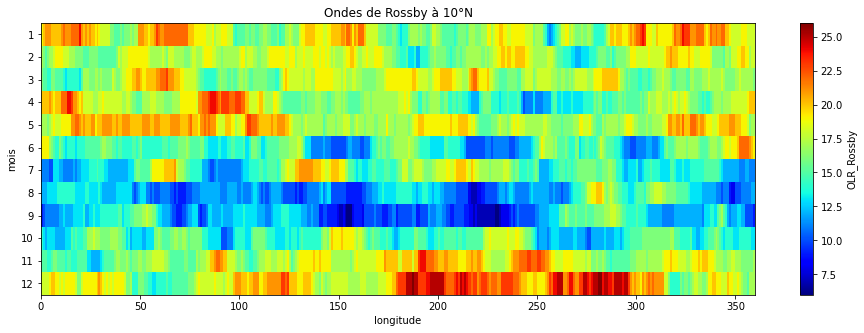

In [12]:
from scipy.signal import find_peaks

# _ds_keep_Rossby = ds_keep_Rossby.sel(lat = 10, method = 'nearest')
ds_nb_jour = ds_keep_Rossby['OLR_Rossby'].astype('int').copy()
ds_nb_jour = ds_nb_jour * 0
# ds_nb_jour.groupby('time.month').mean()
ds_nb_jour

for l in range(ds_keep_Rossby.lon.size):
#     print(l , ' on ', ds_keep_Rossby.lon.size)
    numpy_data = ds_keep_Rossby['OLR_Rossby'].isel(lon = l)
    maxm, _ = find_peaks(numpy_data*-1, distance = 20)
    for m in maxm :
        ds_nb_jour[m,l] = 1
        
data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('Ondes de Rossby à 10°N')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

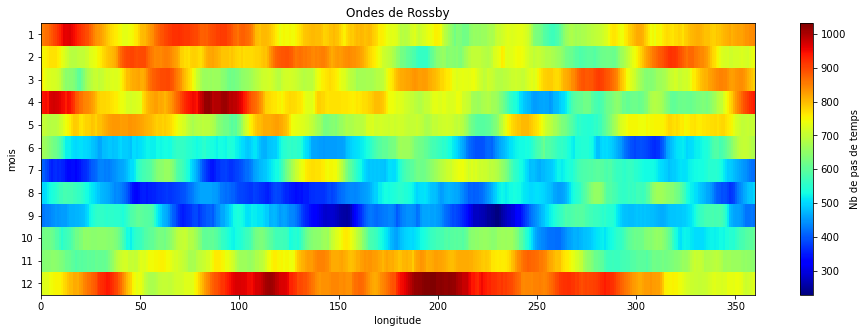

In [13]:
ds_nb_jour = ds_keep_Rossby.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0 + 1

ds_nb_jour = ds_nb_jour.where(ds_keep_Rossby<0, 0,drop= False)
data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot['OLR_Rossby'].plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13), 
                             cbar_kwargs={"label": "Nb de pas de temps"})
plt.title('Ondes de Rossby')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

In [9]:
data_plot

<xarray.Dataset>
Dimensions:           (month: 12, lon: 360)
Coordinates:
    lat               float32 10.5
  * lon               (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    OLR_Rossby        (month, lon) int64 848 859 864 868 876 ... 711 714 721 725
    STD_OLR_Rossby    (month, lon) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    STD_OLR_Rossby_N  (month, lon) int64 4464 4464 4464 4464 ... 4464 4464 4464